# ONT Data Processing

In [1]:
import pathlib
import tomllib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import poreflow as pf  # poreFlow import

In this example, all the parameters are loaded from a single TOML file, to make it easy to keep track of the parameters used.

In [2]:
with open("parameters.toml", "rb") as f:
    config = tomllib.load(f)

input_config = config["input"]
data_name = input_config["name"]
data_path = pathlib.Path(input_config["path"]) / input_config["file"]

## Visually confirm open state

Polynomial([ 2.56579552e+02, -1.27303777e-03], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

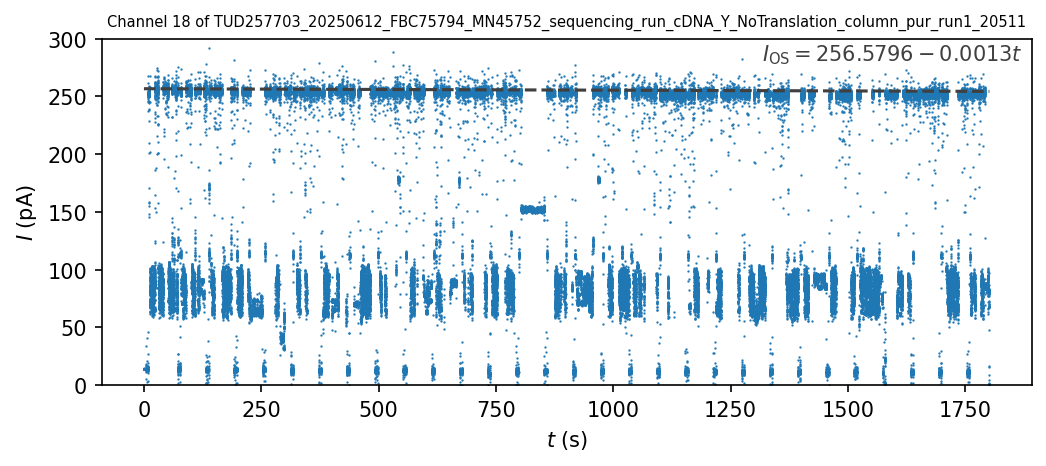

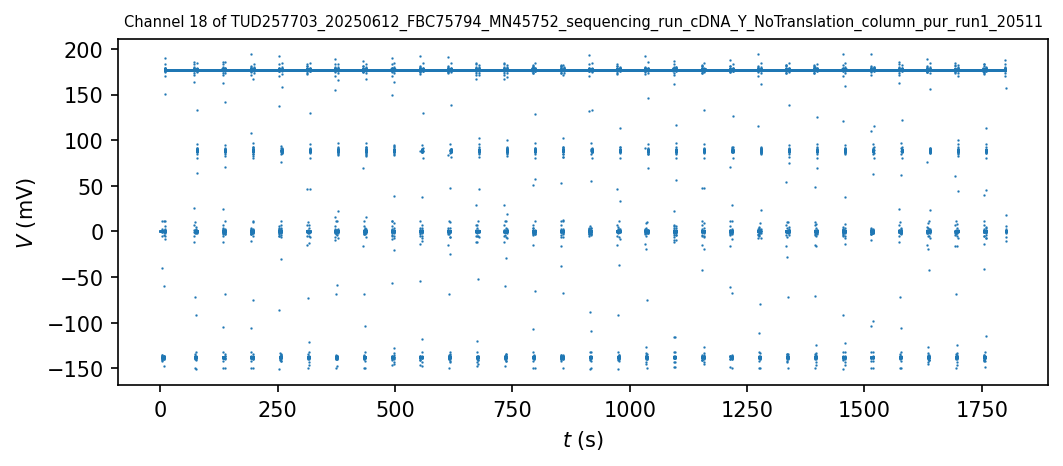

In [3]:
with pf.File(data_path) as f:
    raw = f.get_raw(18)  # Any of the 512 Channels in the ONT file

ylim = config["plot"]["current_range"]

raw.plot().set_ylim(*ylim)
raw.plot("v")
raw.ios

## Find events in one channel

Event finding paramaters

In [4]:
events = raw.find_events(**config["event_finding"])

if events is None:
    print("No events found")

events = events.filter_by_duration()
events.head()

,start_idx,end_idx,n_pts,start_time,end_time,duration,ios,channel,quality,label
0,5,46363,46358,0.0010,9.2726,9.2716,256.573649,18,0.0,0
1,59602,118670,59068,11.9204,23.7340,11.8136,256.556858,18,0.0,0
2,153648,205506,51858,30.7296,41.1012,10.3716,256.533831,18,0.0,0
3,259337,298494,39157,51.8674,59.6988,7.8314,256.508538,18,0.0,0
4,303058,323739,20681,60.6116,64.7478,4.1362,256.499759,18,0.0,0


(0.0, 300.0)

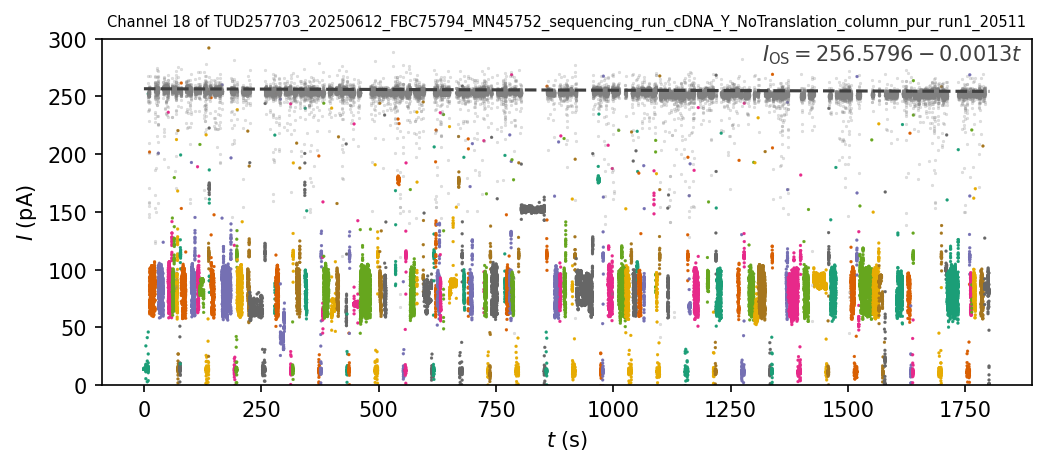

In [5]:
ax = raw.plot_with_events(events, s=2, palette="Dark2")
raw.plot_ios(ax)
ax.set_ylim(*ylim)

## Find events

In first 30 channels

In [6]:
n_workers = config["env"]["n_jobs"]
verbose = config["env"]["verbose"]

channel_list = np.arange(0, 30)


with pf.File(data_path, "r+") as f:
    if not f.has_events or True:
        f.find_events(verbose=verbose, channels=channel_list, **config["event_finding"])

    events = f.get_events()

Starting...:   0%|          | 0/30 [00:00<?, ?it/s]

Starting 8 workers for 30 items
------- SUMMARY -------
Searched 30 channels and found 2847 events. 
Error finding events in 13 channels (43%), channels 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, .... 
Good channels had 167.47 events on average.


## Plot channels with events

In [7]:
from poreflow.plots import plot_raw_with_events_worker

with pf.File(data_path, "r") as f:
    f.map(
        plot_raw_with_events_worker,
        channel_list,
        out=config["plot"]["out"],
        verbose=verbose,
        palette="Dark2",
        ylim=ylim,
    )

Starting...:   0%|          | 0/30 [00:00<?, ?it/s]

Starting 8 workers for 30 items


## Find steps

In [8]:
with pf.File(data_path, "r+") as f:
    if not f.has_steps or True:
        f.find_steps(verbose=verbose, **config["step_finding"])
    steps = f.get_steps()

Starting...:   0%|          | 0/2847 [00:00<?, ?it/s]

Starting 8 workers for 2847 items
------- SUMMARY -------
Found steps in 2847 events. 
Unable to find steps in 0 (0%) events. 
Found a total of 237462 steps. 
Good channels had 83.41 steps on average.


In [9]:
steps.head()

,start_idx,end_idx,std,mean,n_pts,start_time,end_time,dwell_time,event,step_idx
0,0,20360,1.291435,10.932495,20360,0.0000,4.0720,4.0720,0,0
1,20360,20389,72.259405,-275.069747,29,4.0720,4.0778,0.0058,0,1
2,20389,20399,11.278742,-176.649385,10,4.0778,4.0798,0.0020,0,2
3,20399,20423,6.236974,-142.862855,24,4.0798,4.0846,0.0048,0,3
4,20423,20956,1.573807,-131.281231,533,4.0846,4.1912,0.1066,0,4


## Filter events

Adding more features

In [11]:
from poreflow.events import selection

with pf.File(data_path) as f:
    stats = selection.get_step_finding_stats(f)

stats.head()

,start_idx,end_idx,n_pts,start_time,end_time,duration,ios,channel,quality,label,std_of_step_means,n_steps,step_rate,binned_entropy_of_means
0,5,35549,35544,0.0010,7.1098,7.1088,247.891636,10,0.0,0,47.793194,45,6.330182,0.122041
1,35561,46376,10815,7.1122,9.2752,2.1630,247.890282,10,0.0,0,141.771040,7,3.236246,1.604203
2,76130,79006,2876,15.2260,15.8012,0.5752,247.888146,10,0.0,0,9.907781,6,10.431154,2.251629
3,106189,107026,837,21.2378,21.4052,0.1674,247.886451,10,0.0,0,46.897340,4,23.894863,0.500000
4,115210,115752,542,23.0420,23.1504,0.1084,247.885933,10,0.0,0,2.135599,3,27.675277,0.528321


Using features to filter steps 

<Axes: xlabel='event', ylabel='condition'>

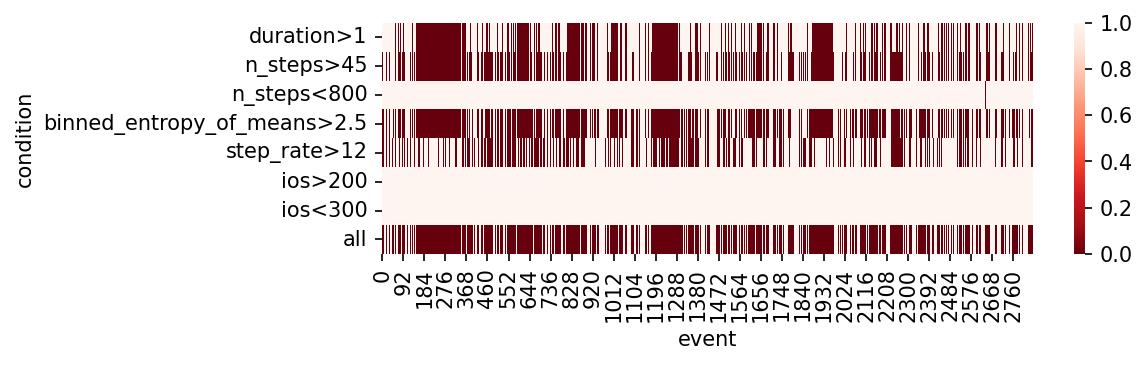

In [13]:

truth_table = selection.filter_from_config(stats, config["event_filtering"])

fig, ax = plt.subplots(figsize=(7, 2), dpi=150)
sns.heatmap(truth_table.T, cmap="Reds_r", ax=ax, vmin=0, vmax=1)

In [14]:
mask = truth_table["all"]
print(f"Selecting {sum(mask)} out of {len(mask)} events ({sum(mask) / len(mask):.0%})")

Selecting 899 out of 2847 events (32%)


In [15]:
with pf.File(data_path, "r+") as f:
    f.filter_events(mask)

## Viewing an event

,start_idx,end_idx,std,mean,n_pts,start_time,end_time,dwell_time,event,step_idx
4502,0,10,73.239370,139.448289,10,0.0000,0.0020,0.0020,20,0
4503,10,31,1.269937,88.308211,21,0.0020,0.0062,0.0042,20,1
4504,31,55,1.784015,82.126371,24,0.0062,0.0110,0.0048,20,2
4505,55,145,2.042542,88.266388,90,0.0110,0.0290,0.0180,20,3
4506,145,253,2.029579,82.786954,108,0.0290,0.0506,0.0216,20,4
...,...,...,...,...,...,...,...,...,...,...
4689,45999,46105,1.909000,114.354885,106,9.1998,9.2210,0.0212,20,187
4690,46105,46354,3.619553,123.863759,249,9.2210,9.2708,0.0498,20,188
4691,46354,46427,1.431253,118.545651,73,9.2708,9.2854,0.0146,20,189
4692,46427,46549,1.965099,121.932373,122,9.2854,9.3098,0.0244,20,190


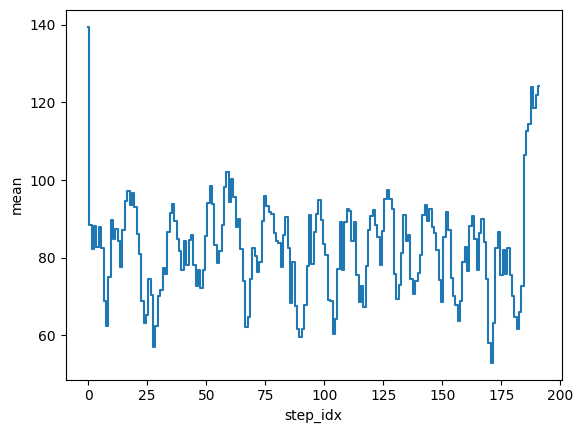

In [16]:
with pf.File(data_path) as f:
    steps = f.get_steps(20)

sns.lineplot(steps, x="step_idx", y="mean", drawstyle="steps-mid")
steps

<Axes: xlabel='step_idx', ylabel='mean'>

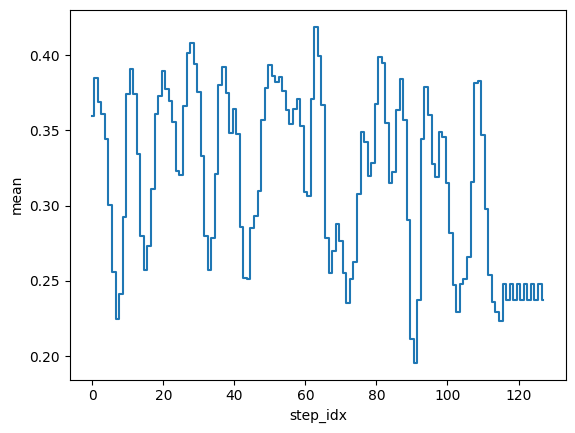

In [19]:
# seq from 5' to 3'
from poreflow.steps import predict

seq = "tttttttttttCCTTTTATCGTCATCATCTTTGTAATCGCCGCTGTAGCTGCCATCGCTGCCTTCGCTT"

steps_dna = predict.predict(seq)

sns.lineplot(steps_dna, x="step_idx", y="mean", drawstyle="steps-mid")